Here we load the saved model from /Modeling/Results/Trained_Models and perform 2 tasks:
1. Visualise the reconstructions of the model
2. Generate deliverable images which highlight diseased subpatches ie the localised disease areas in the entire sugarbeet field

The model used here is: '3D_AE_temporal_addition', which is 3D Convolutional Autoencoder with temporal emdeddings as addition in the forward function.



## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
from pathlib import Path

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
sys.path.append('/home/k64835/Master-Thesis-SITS')

scripts_path = Path("../Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))

scripts_path = Path("../Evaluation/").resolve()
sys.path.append(str(scripts_path))

In [3]:
import pickle
import time
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from scripts.data_visualiser import *
from sklearn.manifold import TSNE 
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from model_scripts.subpatch_extraction import *
from Experimentation.expt_scripts.expt_plots import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.model_helper import *
from model_scripts.dataset_creation import *
from model_scripts.executions import *
from model_scripts.train_model_ae import *
from model_scripts.model_visualiser import *
from model_scripts.clustering import *
from evaluation_scripts.evaluation_helper import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
import numpy as np
import config as config
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure
import torch
import torch.nn as nn
import torch.optim as optim

## Data Prep: Time Embeddings Addition in Encoder

Data: Extracted and Pre-processed Patches (each patch containing a sugarbeet field)

Dimensions: (N, T, C, H, W) = (N, 7, 10, 64, 64)

In [4]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers_train, acquisition_dates_train, date_emb_train, patch_tensor_train, images_visualisation_train = preprocessing_pipeline.get_processed_temporal_cubes('train', 'b10_add', method='sin-cos')
field_numbers_eval, acquisition_dates_eval, date_emb_eval, patch_tensor_eval, images_visualisation_eval = preprocessing_pipeline.get_processed_temporal_cubes('eval', 'b10_add', method='sin-cos')
patch_tensor_train.shape, patch_tensor_eval.shape

(torch.Size([1228, 7, 10, 64, 64]), torch.Size([48, 7, 10, 64, 64]))

Dictionary for subpatch-to-patch mapping of reconstructed images

In [5]:
old_images_train = {fn: img for fn, img in zip(field_numbers_train, images_visualisation_train)}
old_images_eval = {fn: img for fn, img in zip(field_numbers_eval, images_visualisation_eval)}

In [6]:
acq_dict_train = {fn: date for fn, date in zip(field_numbers_train, acquisition_dates_train)}
acq_dict_eval = {fn: date for fn, date in zip(field_numbers_train, acquisition_dates_eval)}

Create Sub-Patches

In [7]:
train_subpatches, train_subpatch_coords, train_subpatch_date_emb = non_overlapping_sliding_window_with_date_emb(patch_tensor_train, field_numbers_train, date_emb_train, patch_size=config.subpatch_size)
eval_subpatches, eval_subpatch_coords, eval_subpatch_date_emb = non_overlapping_sliding_window_with_date_emb(patch_tensor_eval, field_numbers_eval, date_emb_eval, patch_size=config.subpatch_size)
train_subpatches.shape, eval_subpatches.shape

Get field numbers and co-ordinates as string

In [ ]:
train_coord_dataloader = get_string_fielddata(train_subpatch_coords)
eval_coord_dataloader = get_string_fielddata(eval_subpatch_coords)
eval_coord_dataloader[0], len(eval_coord_dataloader), len(train_coord_dataloader)

('1168039.0_20_24', 1197, 33128)

Split Unlabeled data into 'train' and 'test' and create  Data Loaders
The data loader function for MAE is used since it is designed to take temporal encodings additionally

In [ ]:
train_subpatches_dl, test_subpatches, train_field_numbers, test_field_numbers, train_date_embeddings, test_date_embeddings = train_test_split(
    train_subpatches, train_coord_dataloader, train_subpatch_date_emb, test_size=1-config.ae_train_test_ratio, random_state=42
)

dataloader_train_add = create_data_loader_mae(train_subpatches_dl, train_field_numbers, train_date_embeddings, mae=False, batch_size=config.ae_batch_size, shuffle=True)
dataloader_test_add = create_data_loader_mae(test_subpatches, test_field_numbers, test_date_embeddings, mae=False, batch_size=config.ae_batch_size, shuffle=False)
dataloader_eval_add = create_data_loader_mae(eval_subpatches, eval_coord_dataloader, eval_subpatch_date_emb, mae=False, batch_size=config.ae_batch_size, shuffle=False)

## Load Saved Model

In [ ]:
class Conv3DAutoencoder_Time_Addition(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv3DAutoencoder_Time_Addition, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels
        self.patch_size = patch_size

        # --- Encoder (3D Convolutions) ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size * time_steps, 512)   
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size * time_steps)

        # --- 3D Deconvolutions (Transpose convolutions) ---
        self.unflatten = nn.Unflatten(1, (256, time_steps, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1)

        # --- Temporal embedding projection to match channels (needed for alignment) ---
        self.temb_proj = nn.Conv3d(2, in_channels, kernel_size=1)


    def forward(self, x, date_embeddings):

        # --- Date embedding processing ---
        # Convert the date embeddings to the shape (B, 2, 7, 4, 4)
        if not isinstance(date_embeddings, torch.Tensor):
            date_embeddings = torch.tensor(date_embeddings, dtype=torch.float32).to(x.device)    # Shape: (B, 7, 2)
        date_embeddings_tensor = date_embeddings.permute(0, 2, 1)                                # Shape: (B, 2, 7)
        date_embeddings_tensor = date_embeddings_tensor.unsqueeze(-1).unsqueeze(-1)                     # Shape: (B, 2, 7, 1, 1)
        date_embeddings_tensor = date_embeddings_tensor.expand(-1, -1, -1, x.shape[3], x.shape[4])      # Shape: (B, 2, 7, 4, 4)

        # Project the date embeddings to match the channels
        date_embeddings_tensor = date_embeddings_tensor.float() 
        date_embeddings_tensor = self.temb_proj(date_embeddings_tensor)                                 # Shape: (B, 10, 7, 4, 4)
        # print('x shape before time embedding:',x.shape)
        # print('time embeddings:',date_embeddings_tensor.shape)
        
        # --- Add date embeddings to the input tensor ---
        x = x + date_embeddings_tensor                                                                  # Shape: (B, 10, 7, 4, 4)
        # print('x shape after time embedding',x.shape)
        
        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        b, c, t, h, w = x.shape                 # (B, C, T, H, W)
        x = self.flatten(x)  
        x = F.relu(self.fc1(x))
        z = self.fc2(x)                         # Bottleneck    

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- Reshape and 3D Deconvolutions ---
        x = self.unflatten(x)                   # (B, C, H, W, T)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)       # Reconstruction

        return z, x_reconstructed

In [ ]:
channels = 10
time_steps = 7
latent_dim = 32
device = 'cuda'
trained_model = Conv3DAutoencoder_Time_Addition(channels, time_steps, latent_dim, config.subpatch_size)

with open(config.best_model_path, 'rb') as file:
    trained_model = pickle.load(file)

## 1. Reconstructions

Visualise Sub-patch-level Reconstructions => Random Image

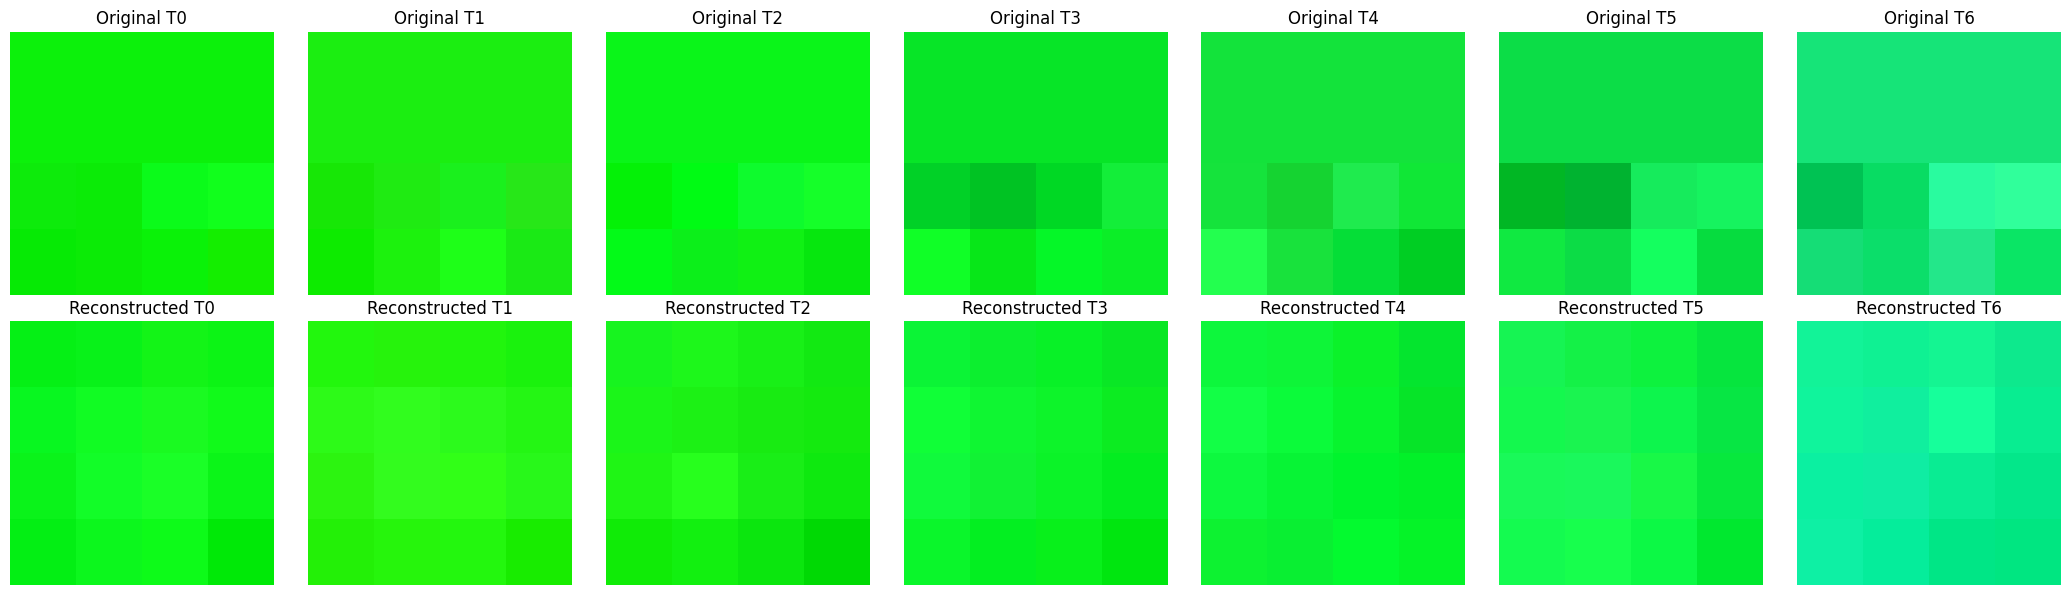

In [25]:
plot_reconstructed_subpatches_temporal(trained_model, dataloader_train_add, 1, device, model_type='ae_te')

Map subpatch-level to patches and Visualise Patch level reconstructions => Random Image

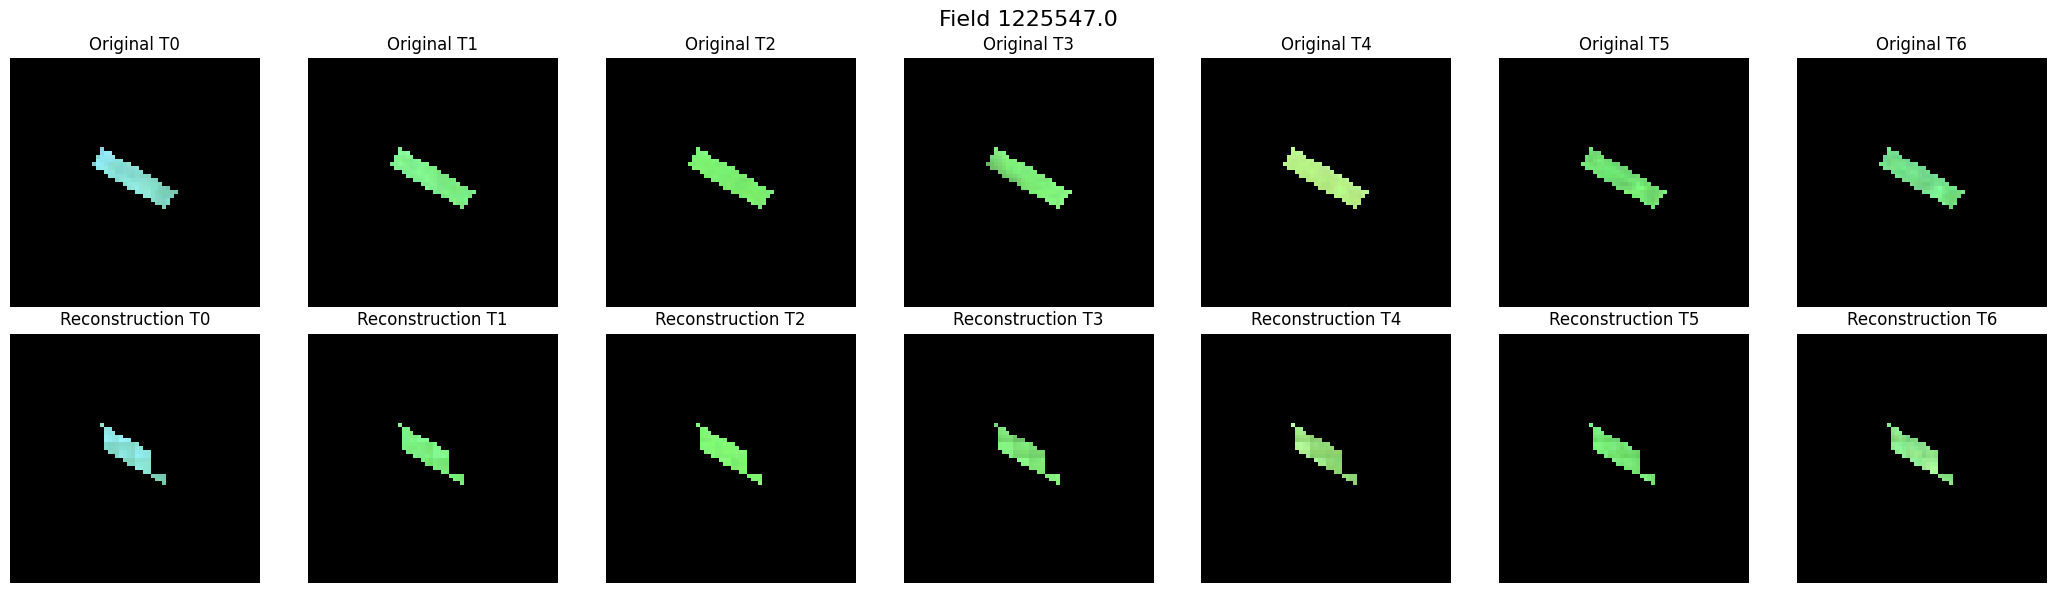

In [26]:
plot_reconstructed_patches_temporal(trained_model, dataloader_eval_add, old_images_eval, 1, device, model_type='ae_te')

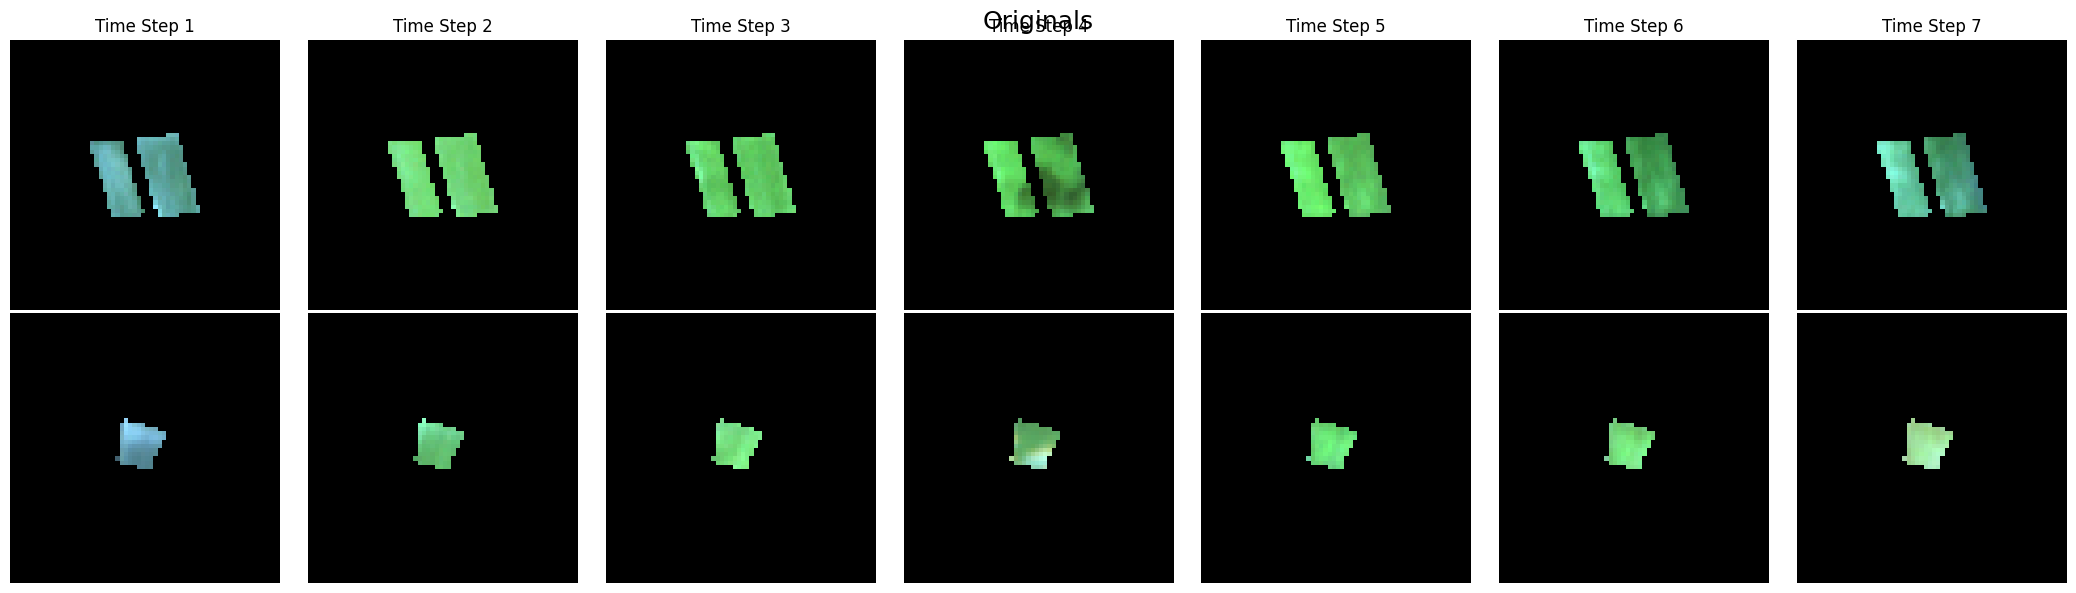

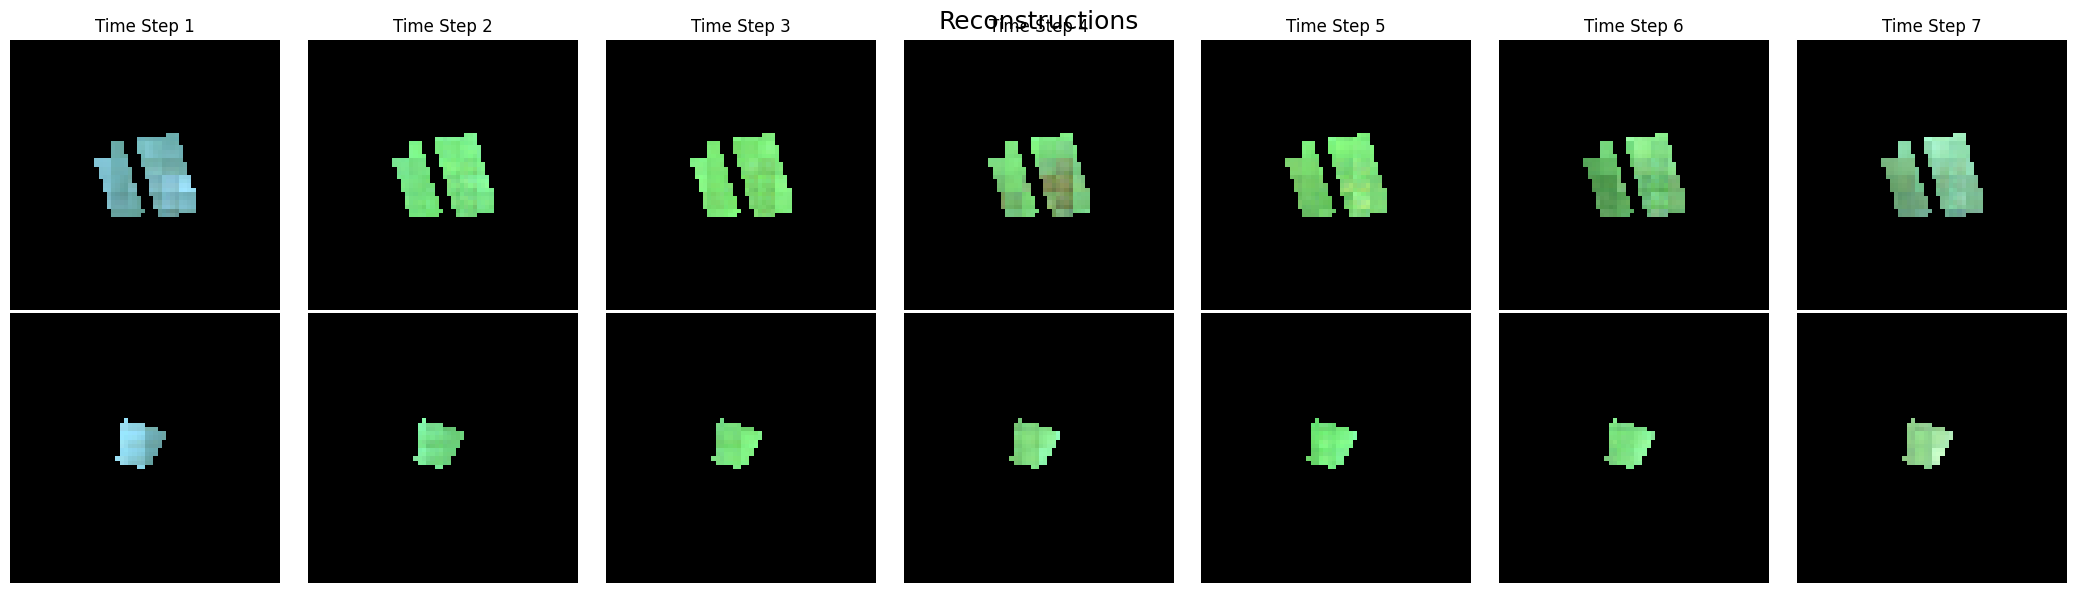

In [143]:
plot_temporal_grid_reconstructions(trained_model, dataloader_eval_add, old_images_eval, device=device, model_type='ae_te', num_fields=2)

## 2. Diseased Subpatch Mapping

### Extract Features for the data and cluster using k-means

In [ ]:
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train_add, temp_embed_pixel=True, device=device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test_add, temp_embed_pixel=True, device=device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval_add, temp_embed_pixel=True, device=device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [ ]:
kmeans = kmeans_function(combined_train_features, n_clusters=2, random_state=29)

train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

Clustering Accuracy

In [ ]:
disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_dl, eval_subpatch_predictions, config.labels_path, config.subpatch_to_patch_threshold)
print("Disease cluster:", disease)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1_score)
print("F2-score:", f2_score)

Disease cluster: 0
Accuracy: 68.85
Precision: 69.05
Recall: 82.86
F1-score: 75.32
F2-score: 79.67


Assign field labels to training data for creating final visualisation images

In [ ]:
train_field_labels = assign_field_labels_ae_train(combined_train_coords, train_subpatch_predictions, disease, config.subpatch_to_patch_threshold) #for box drawing

In [ ]:
len(field_numbers_train)

### Draw Diseased subpatches

In [121]:
eval_prediction_dict = dict(zip(eval_coord_dataloader, eval_subpatch_predictions))
train_prediction_dict = dict(zip(train_coord_dataloader, train_subpatch_predictions))

Eval Set

In [122]:
draw_diseased_patches_temporal(images_visualisation_eval, eval_prediction_dict, config.deliverable_images_save_path, config.subpatch_size)

Saved: /home/k64835/SITS-images/output/train/1168039.png
Saved: /home/k64835/SITS-images/output/train/1228889.png
Saved: /home/k64835/SITS-images/output/train/1168663.png
Saved: /home/k64835/SITS-images/output/train/1168692.png
Saved: /home/k64835/SITS-images/output/train/1171179.png
Saved: /home/k64835/SITS-images/output/train/1171179.png
Saved: /home/k64835/SITS-images/output/train/1172001.png
Saved: /home/k64835/SITS-images/output/train/1174805.png
Saved: /home/k64835/SITS-images/output/train/1176318.png
Saved: /home/k64835/SITS-images/output/train/1176365.png
Saved: /home/k64835/SITS-images/output/train/1177274.png
Saved: /home/k64835/SITS-images/output/train/1177490.png
Saved: /home/k64835/SITS-images/output/train/1177490.png
Saved: /home/k64835/SITS-images/output/train/1178038.png
Saved: /home/k64835/SITS-images/output/train/1178198.png
Saved: /home/k64835/SITS-images/output/train/1179855.png
Saved: /home/k64835/SITS-images/output/train/1182776.png
Saved: /home/k64835/SITS-images

Train Set

In [123]:
draw_diseased_patches_temporal(images_visualisation_train, train_prediction_dict, config.deliverable_images_save_path, config.subpatch_size)

Saved: /home/k64835/SITS-images/output/train/1167136.png
Saved: /home/k64835/SITS-images/output/train/1167141.png
Saved: /home/k64835/SITS-images/output/train/1167168.png
Saved: /home/k64835/SITS-images/output/train/1167170.png
Saved: /home/k64835/SITS-images/output/train/1167194.png
Saved: /home/k64835/SITS-images/output/train/1167204.png
Saved: /home/k64835/SITS-images/output/train/1167204.png
Saved: /home/k64835/SITS-images/output/train/1167215.png
Saved: /home/k64835/SITS-images/output/train/1167222.png
Saved: /home/k64835/SITS-images/output/train/1167224.png
Saved: /home/k64835/SITS-images/output/train/1167367.png
Saved: /home/k64835/SITS-images/output/train/1167414.png
Saved: /home/k64835/SITS-images/output/train/1167419.png
Saved: /home/k64835/SITS-images/output/train/1167422.png
Saved: /home/k64835/SITS-images/output/train/1167526.png
Saved: /home/k64835/SITS-images/output/train/1167531.png
Saved: /home/k64835/SITS-images/output/train/1167532.png
Saved: /home/k64835/SITS-images